In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


img_transform = transforms.Compose([  transforms.ToTensor()  ])

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.reshape(x.size(0), 1, 28, 28)
    return x

def imshow(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


data_dir = './PytorchLearning/fashion_mnist/'
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, 
                                                  transform=img_transform,download=True)
train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True)


val_dataset = torchvision.datasets.FashionMNIST(data_dir, train=False, 
                                                transform=img_transform)
test_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)


#指定设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

100%|██████████| 26421880/26421880 [00:20<00:00, 1278687.56it/s]


Extracting ./PytorchLearning/fashion_mnist/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./PytorchLearning/fashion_mnist/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 163805.75it/s]


Extracting ./PytorchLearning/fashion_mnist/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./PytorchLearning/fashion_mnist/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1432340.79it/s]


Extracting ./PytorchLearning/fashion_mnist/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./PytorchLearning/fashion_mnist/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./PytorchLearning/fashion_mnist/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./PytorchLearning/fashion_mnist/FashionMNIST\raw

cuda:0


In [2]:
class VAE(nn.Module):
    def __init__(self,hidden_1=256,hidden_2=256,
                      in_decode_dim=2,hidden_3=256):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc21 = nn.Linear(hidden_2, 2)
        self.fc22 = nn.Linear(hidden_2, 2)
        self.fc3 = nn.Linear(in_decode_dim, hidden_3)
        self.fc4 = nn.Linear(hidden_3, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mean, lg_var):
        std = lg_var.exp().sqrt()        
        eps = torch.FloatTensor(std.size()).normal_().to(device) 
        eps = torch.FloatTensor(std.size()).normal_().to(device) 
        return eps.mul(std).add_(mean)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x,*arg):
        mean, lg_var = self.encode(x)
        z = self.reparametrize(mean, lg_var)
        return self.decode(z), mean, lg_var


In [5]:
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mean, lg_var):

    MSEloss = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#    KLD_element = mean.pow(2).add_(lg_var.exp()).mul_(-1).add_(1).add_(lg_var)
#    KLD = torch.sum(KLD_element).mul_(-0.5)
    
    KLD = -0.5 * torch.sum(1 + lg_var -  mean.pow(2) - lg_var.exp())

    return MSEloss*0.5 + KLD

def train(model,num_epochs = 50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    display_step = 5
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            img, label = data
            img = img.view(img.size(0), -1).to(device)
            y_one_hot = torch.zeros(label.shape[0],10).scatter_(1,
                                   label.view(label.shape[0],1),1).to(device)
            
            optimizer.zero_grad()
            recon_batch, mean, lg_var = model(img,y_one_hot)
            loss = loss_function(recon_batch, img, mean, lg_var)
            loss.backward()
            train_loss += loss.data
            optimizer.step()  
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(loss.data))
    
    print("完成! cost=",loss.data)   

Epoch: 0001 cost= 1934.881835938
Epoch: 0006 cost= 1650.737792969
Epoch: 0011 cost= 1447.364868164
Epoch: 0016 cost= 1511.555175781
Epoch: 0021 cost= 1548.867797852
Epoch: 0026 cost= 1641.908935547
Epoch: 0031 cost= 1568.337890625
Epoch: 0036 cost= 1558.193847656
Epoch: 0041 cost= 1470.696777344
Epoch: 0046 cost= 1378.513183594
完成! cost= tensor(1608.7312, device='cuda:0')


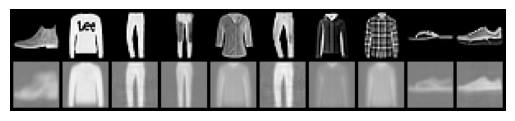

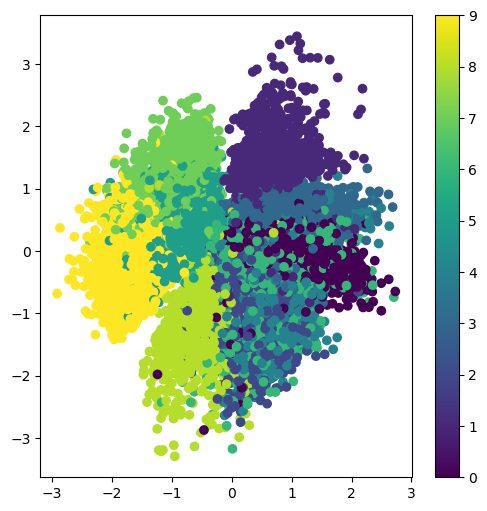

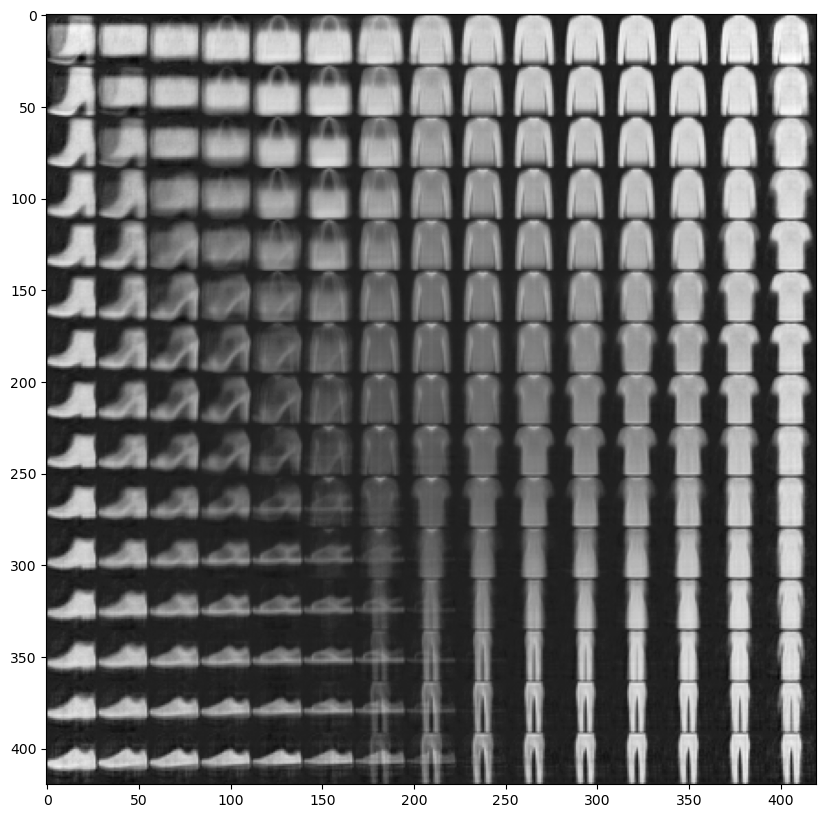

In [8]:
if __name__ == '__main__': 
     
    model = VAE().to(device)
    train(model,50)
    
    # 可视化结果
    sample = iter(test_loader)
    images, labels = next(sample)
    images2 = images.view(images.size(0), -1)
    with torch.no_grad():
        pred, mean, lg_var = model(images2.to(device))
    pred =to_img( pred.cpu().detach())
    rel = torch.cat([images,pred],axis = 0)
    imshow(torchvision.utils.make_grid(rel,nrow=10))


    
    test_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    sample = iter(test_loader)
    images, labels = next(sample)
    with torch.no_grad():
        mean, lg_var = model.encode(images.view(images.size(0), -1).to(device))
        z = model.reparametrize(mean, lg_var)
    z =z.cpu().detach().numpy()
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0], z[:, 1], c=labels)
    plt.colorbar()
    plt.show()
    
    

    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):

            z_sample= torch.FloatTensor([[xi, yi]]).reshape([1,2]).to(device)            
            x_decoded = model.decode(z_sample).cpu().detach().numpy()
            
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()  